## Importing Packages

In [1]:
# ignore warnings in the notebook
import warnings
warnings.filterwarnings('ignore')

In [2]:
# import initial packages
import numpy as np
import pandas as pd
# settings to display all columns
pd.set_option("display.max_columns", None)

In [3]:
# import visualizations package
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import tree
import graphviz

In [4]:
# Preprocessing packages
from statsmodels.stats.outliers_influence import variance_inflation_factor
import category_encoders as ce
from sklearn.preprocessing import StandardScaler, RobustScaler, QuantileTransformer, PowerTransformer
from sklearn.model_selection import train_test_split
# Modelling packages
from sklearn.linear_model import LogisticRegression
import statsmodels.api as sm
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
# Evaluation metrics packages
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_score,recall_score, f1_score, roc_auc_score, roc_curve, auc
from sklearn.metrics import roc_auc_score,roc_curve,auc

In [5]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:99% !important; }</style>"))

## Understanding the Data

In [6]:
# import the initial dataset
data_original = pd.read_csv('./credit_risk_dataset.csv')
data=data_original

In [7]:
data.head()

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,22,59000,RENT,123.0,PERSONAL,D,35000,16.02,1,0.59,Y,3
1,21,9600,OWN,5.0,EDUCATION,B,1000,11.14,0,0.10,N,2
2,25,9600,MORTGAGE,1.0,MEDICAL,C,5500,12.87,1,0.57,N,3
3,23,65500,RENT,4.0,MEDICAL,C,35000,15.23,1,0.53,N,2
4,24,54400,RENT,8.0,MEDICAL,C,35000,14.27,1,0.55,Y,4


In [8]:
# put the response as the last column for convinience
cols = data.columns.tolist()
cols.remove('loan_status')
cols.append('loan_status')
cols
data=data[cols]

In [9]:
# drop duplicate data points
data.drop_duplicates(inplace=True)

In [10]:
data.describe()

,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,loan_status
count,32416.000000,3.241600e+04,31529.00000,32416.000000,29321.000000,32416.000000,32416.000000,32416.000000
mean,27.747008,6.609164e+04,4.79051,9593.845632,11.017265,0.170250,5.811297,0.218688
std,6.354100,6.201558e+04,4.14549,6322.730241,3.241680,0.106812,4.059030,0.413363
min,20.000000,4.000000e+03,0.00000,500.000000,5.420000,0.000000,2.000000,0.000000
25%,23.000000,3.854200e+04,2.00000,5000.000000,7.900000,0.090000,3.000000,0.000000
50%,26.000000,5.500000e+04,4.00000,8000.000000,10.990000,0.150000,4.000000,0.000000
75%,30.000000,7.921800e+04,7.00000,12250.000000,13.470000,0.230000,8.000000,0.000000
max,144.000000,6.000000e+06,123.00000,35000.000000,23.220000,0.830000,30.000000,1.000000


In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 32416 entries, 0 to 32580
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   person_age                  32416 non-null  int64  
 1   person_income               32416 non-null  int64  
 2   person_home_ownership       32416 non-null  object 
 3   person_emp_length           31529 non-null  float64
 4   loan_intent                 32416 non-null  object 
 5   loan_grade                  32416 non-null  object 
 6   loan_amnt                   32416 non-null  int64  
 7   loan_int_rate               29321 non-null  float64
 8   loan_percent_income         32416 non-null  float64
 9   cb_person_default_on_file   32416 non-null  object 
 10  cb_person_cred_hist_length  32416 non-null  int64  
 11  loan_status                 32416 non-null  int64  
dtypes: float64(3), int64(5), object(4)
memory usage: 3.2+ MB


We see that we have a lot of data points to use for modelling and comparatively not a lot of null values in our data. Therefore dropping the rows containing null values shouldn't be that big of an issue.\
We also notice we have 4 categorical features and 7 numerical features initially.

In [12]:
# split the features and response
y=data['loan_status']
x=data.drop(['loan_status'], axis=1)

<Axes: xlabel='loan_status', ylabel='count'>

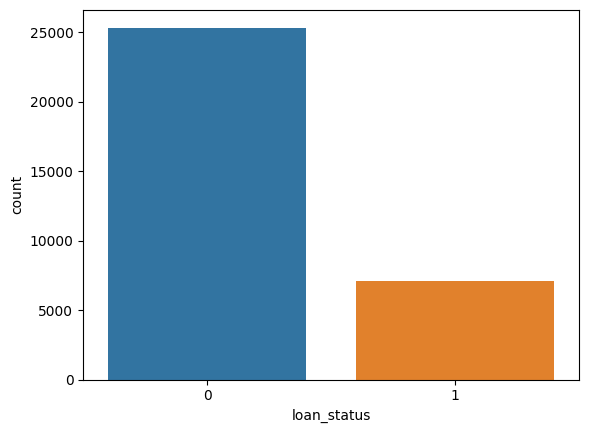

In [13]:
# check distribution of response
sns.countplot(x=y)

Around 20% of our sample has defaulted(1) and 80% didn't default(0). This is an example of an imbalanced dataset.\
However, our class imbalance doesn't seem high enough that we would be using any of the over/under-sampling techniques.

In [14]:
# splitting into categorical and numerical dataframes for ease of analysis
data_cat=x.select_dtypes(include=['object'])
data_num=x.select_dtypes(include=['number'])

In [15]:
# finding our the categories in each categorical columns
for i in data_cat.columns:
    print(i, ' -> ', data_cat[i].unique())

person_home_ownership  ->  ['RENT' 'OWN' 'MORTGAGE' 'OTHER']
loan_intent  ->  ['PERSONAL' 'EDUCATION' 'MEDICAL' 'VENTURE' 'HOMEIMPROVEMENT'
 'DEBTCONSOLIDATION']
loan_grade  ->  ['D' 'B' 'C' 'A' 'E' 'F' 'G']
cb_person_default_on_file  ->  ['Y' 'N']


Our categorical features have low cardinality so they are viable enough to use in our modelling. (There would be difficulty in encoding them otherwise for example.)

### Basic Visualizations for basic inferences

In [16]:
# defining a function for reusability
def kde(df):
    fig,axes = plt.subplots(nrows=len(df.columns), figsize=(10,len(df.columns)*5))
    for i,j in zip(df.columns, range(0, len(df.columns))):
        sns.kdeplot(x=df[i], shade=True, ax=axes[j])

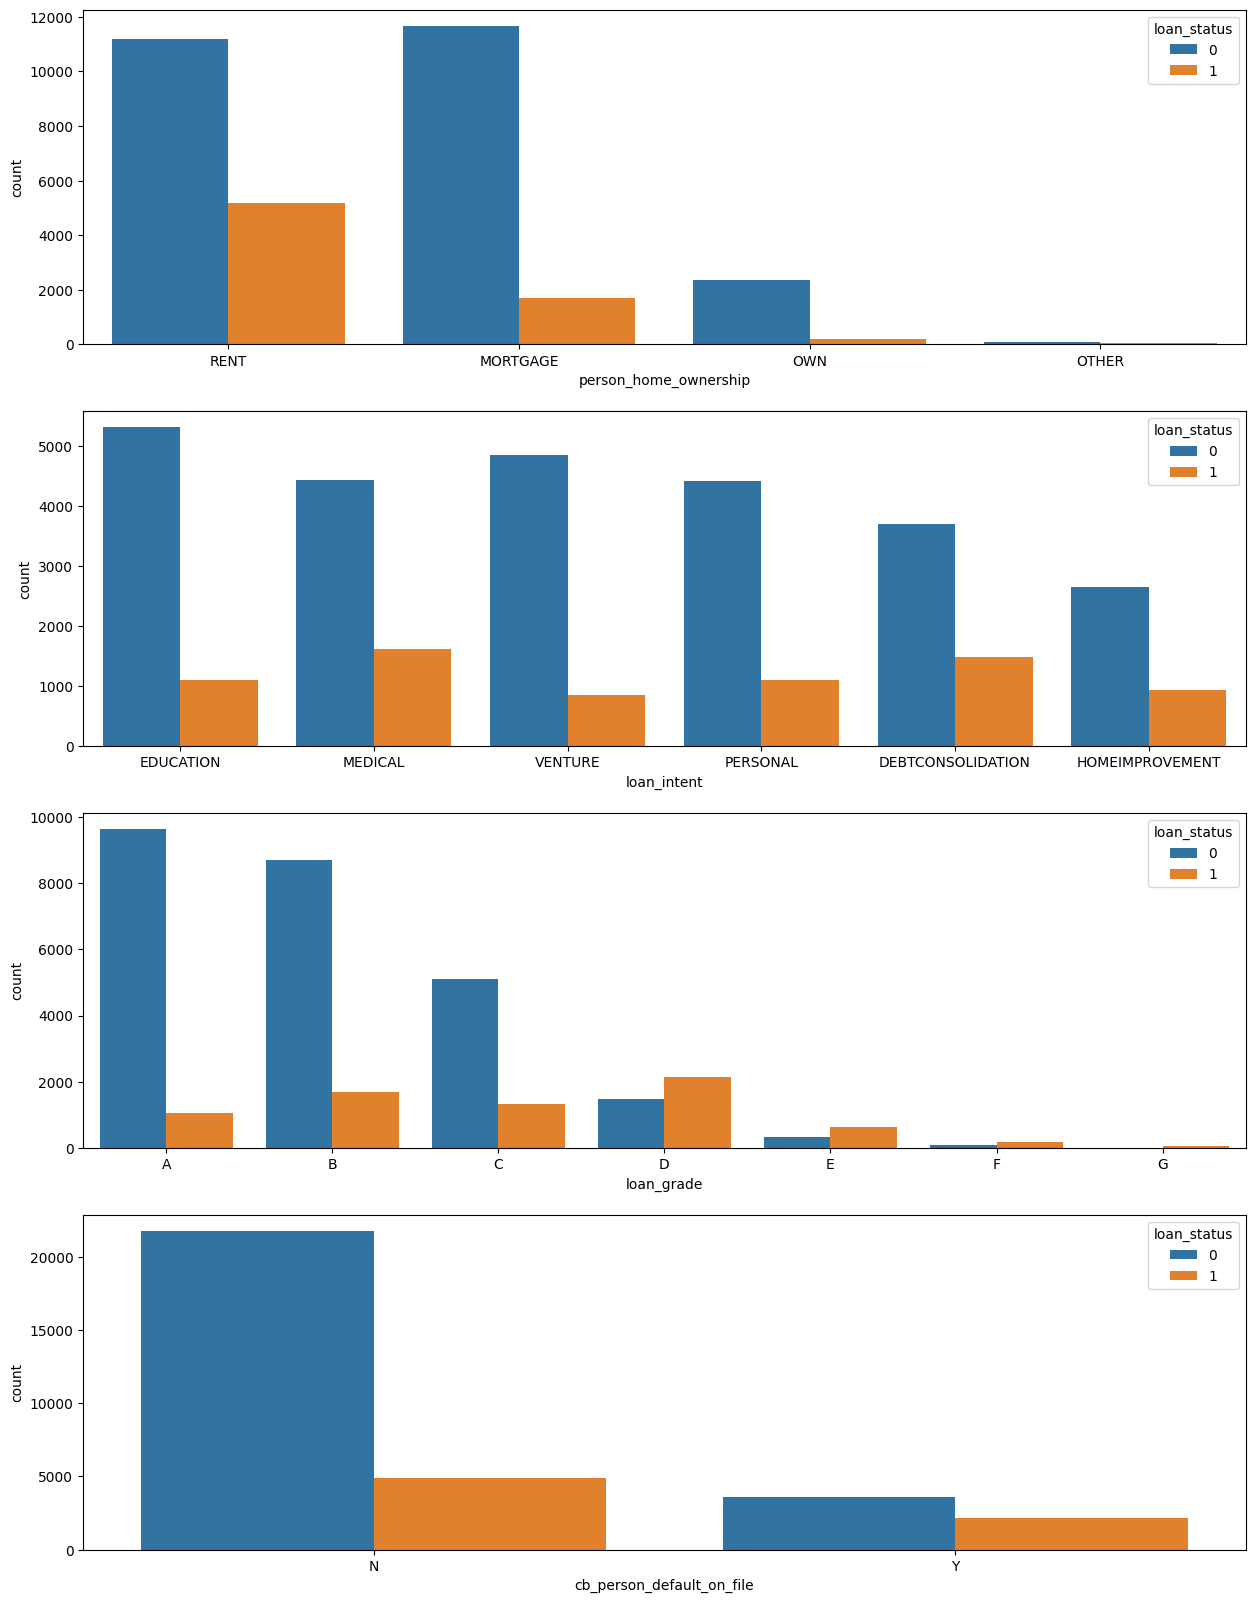

In [17]:
# Visualization of categorical variables
fig,axes = plt.subplots(nrows=len(data_cat.columns), figsize=(15,len(data_cat.columns)*5))
for i,j in zip(data_cat.columns, range(0, len(data_cat.columns))):
    sns.countplot(x=data_cat[i], hue=y, ax=axes[j], order=data_cat[i].value_counts().index)

- person_home_ownership
    - most people applying for loan are either renting accomodations or have a mortgage on their home. This makes sense as neither the very rich or very poor people would apply for loans.
- loan_intent
    - there is little variation in the reason why people are applying for loans with education being the most common reason and home improvement being the least common.
- loan_grade
    - A,B and C are the most common classifications. This seems to fall in line because most people do not default and therefore are given better grades.
- cb_person_default_on_file
    - most people have previously not defaulted.

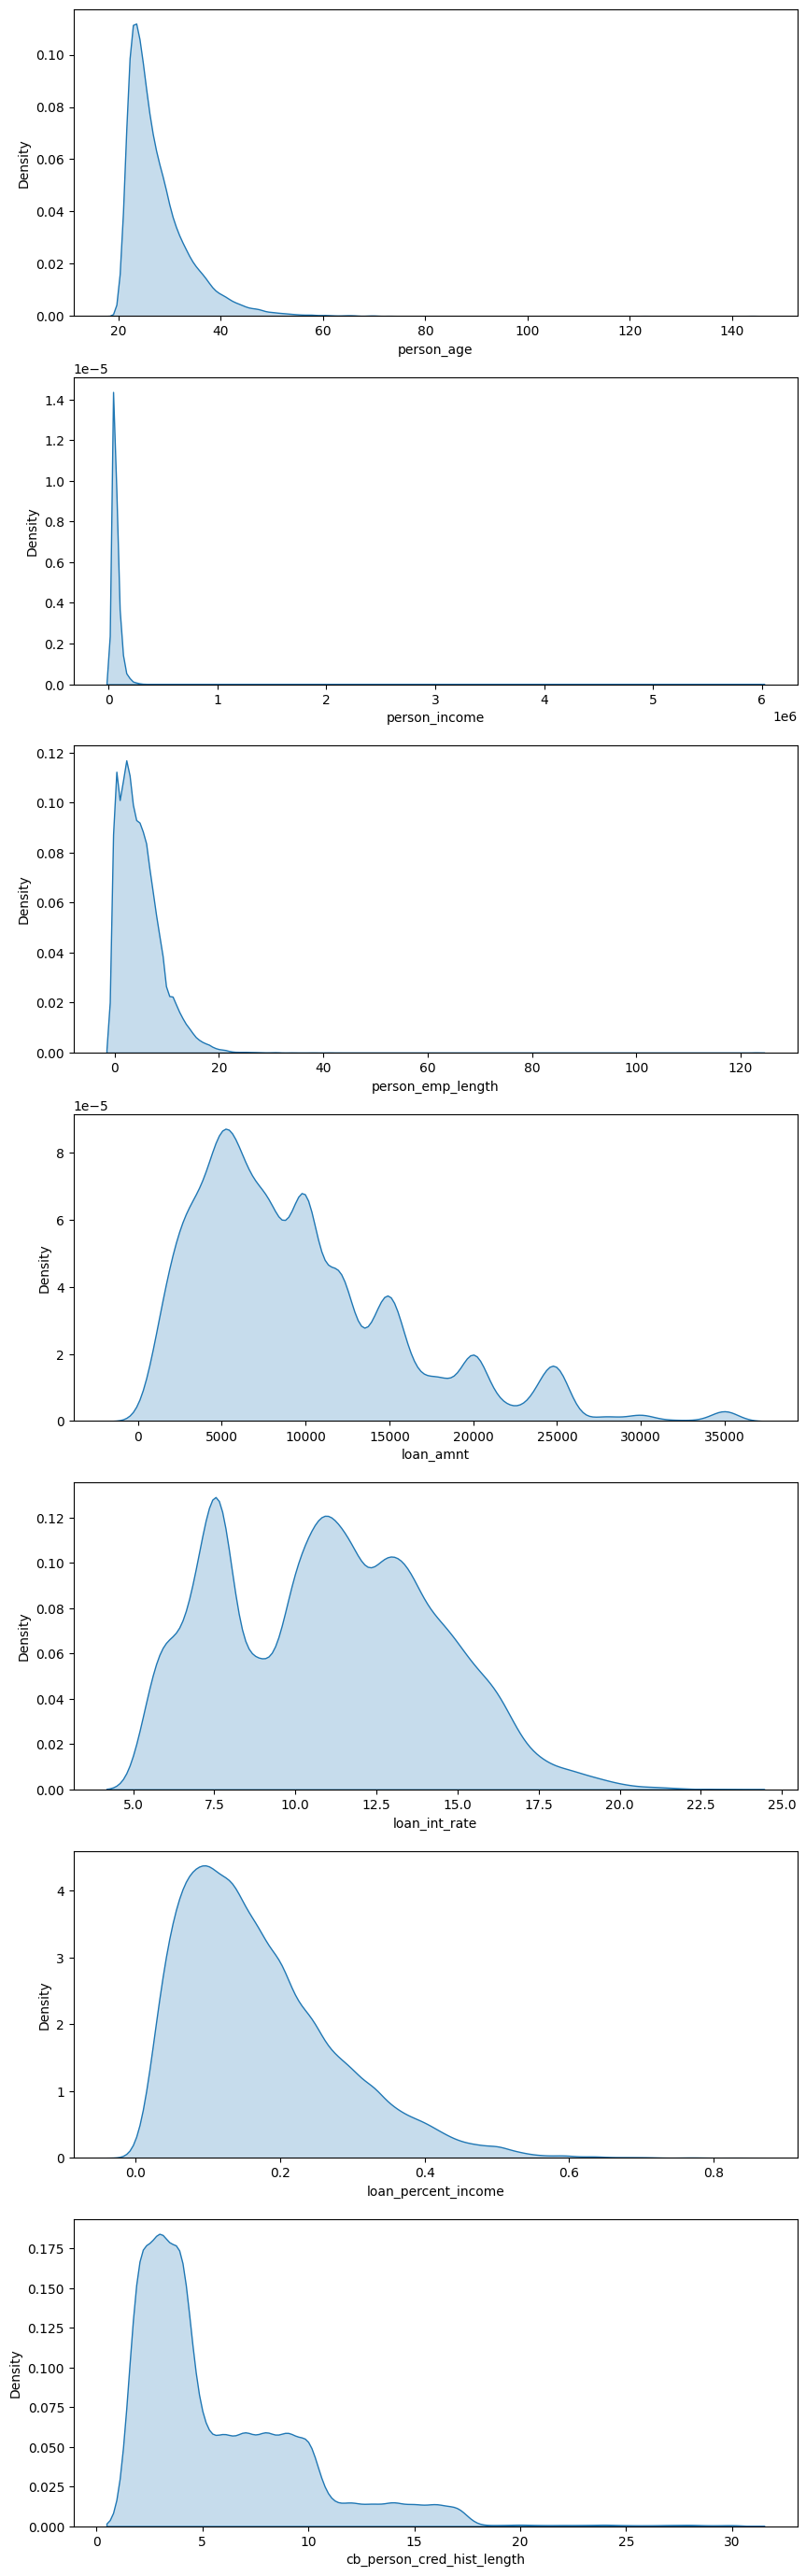

In [18]:
# Visualization of numerical variables
kde(data_num)

Most of the data seems to be normally distributed. 
- person_age
    - most people applying for loans are in their 20s. This follows logically as people's capacity to repay loans is much more during younger ages.
    - some of the samples have age of even over 100 so this indicates some error during sample.
- person_income
    - 

## DATA CLEANING AND FEATURE ENGINEERING

In [19]:
# Removing outliers
data = data[~(data['person_age'] > 60)]
data = data[~(data['person_income'] > 1000000)]
data = data[~(data['person_emp_length'] > 40)]
# Removing rows with missing values
data=data.dropna()

In [20]:
y=data['loan_status']
x=data.drop(['loan_status'], axis=1)
data_cat=x.select_dtypes(include=['object'])
data_num=x.select_dtypes(include=['number'])

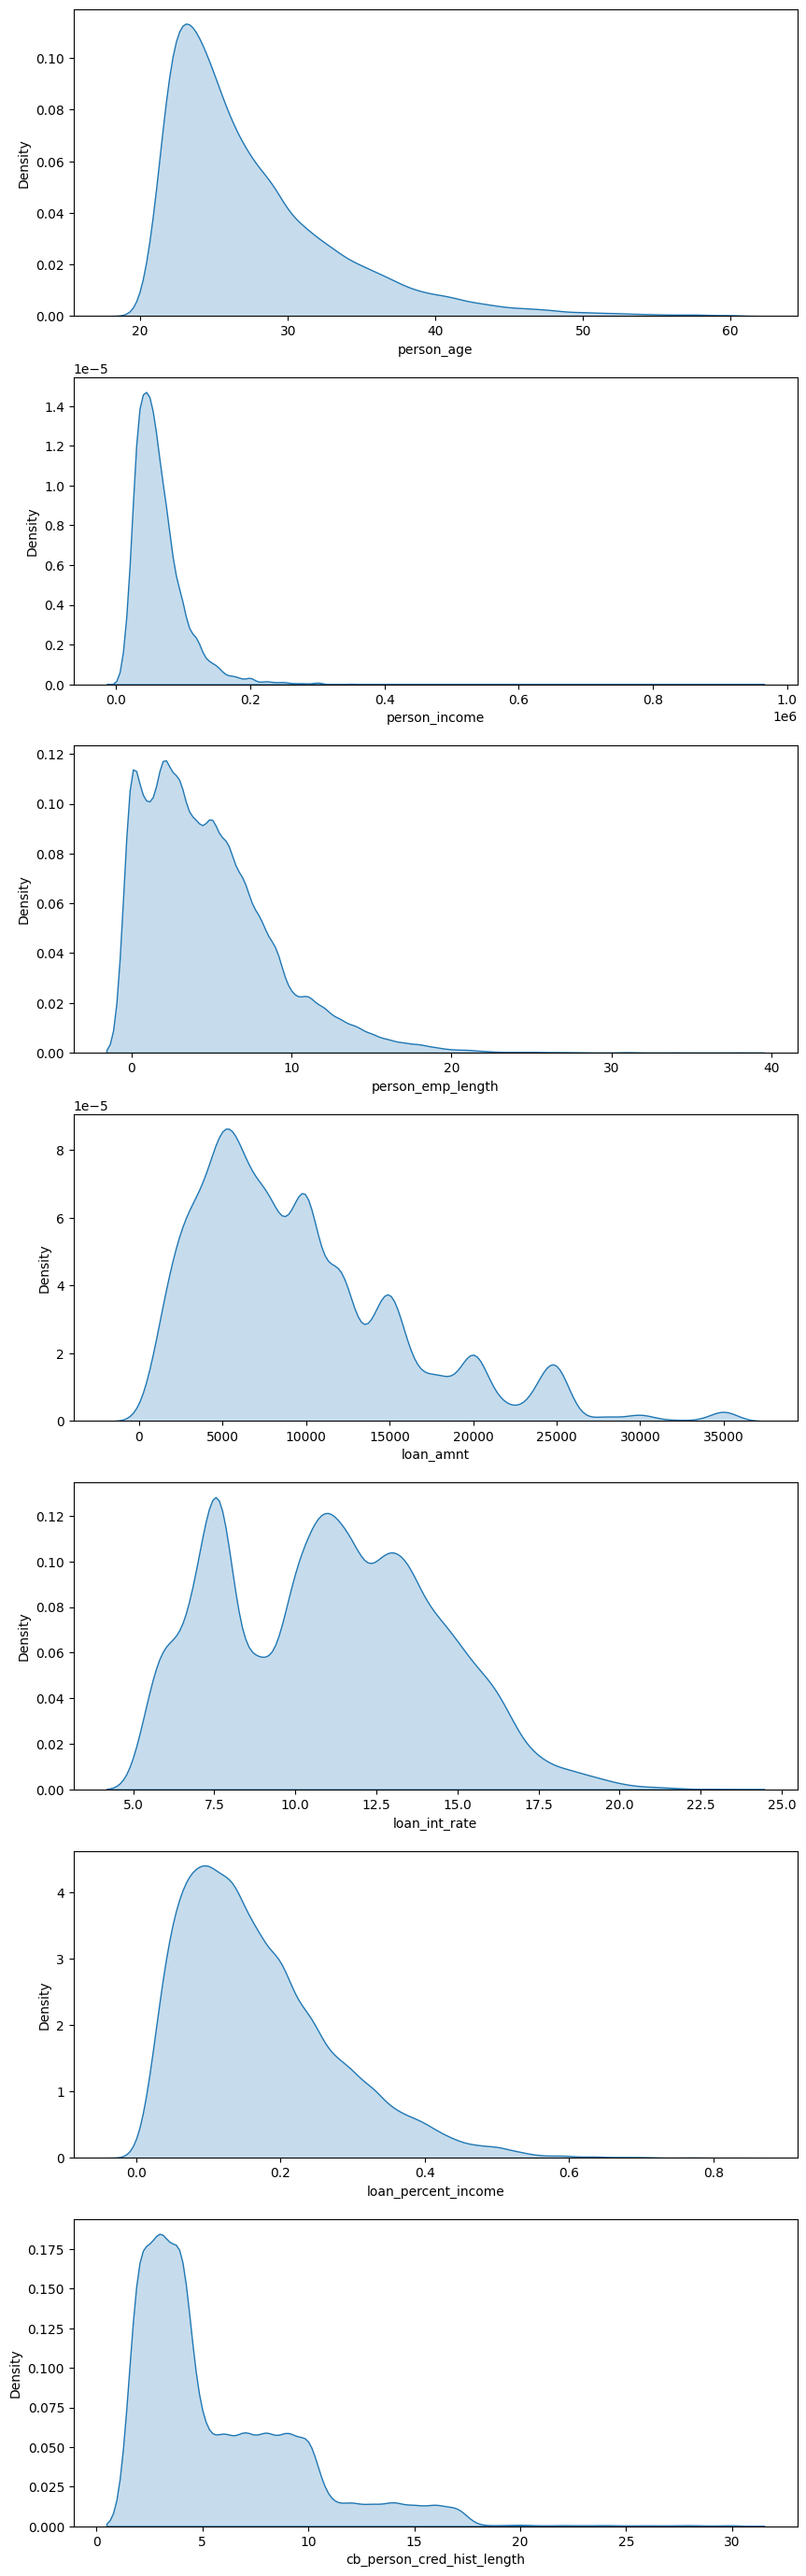

In [21]:
kde(data_num)

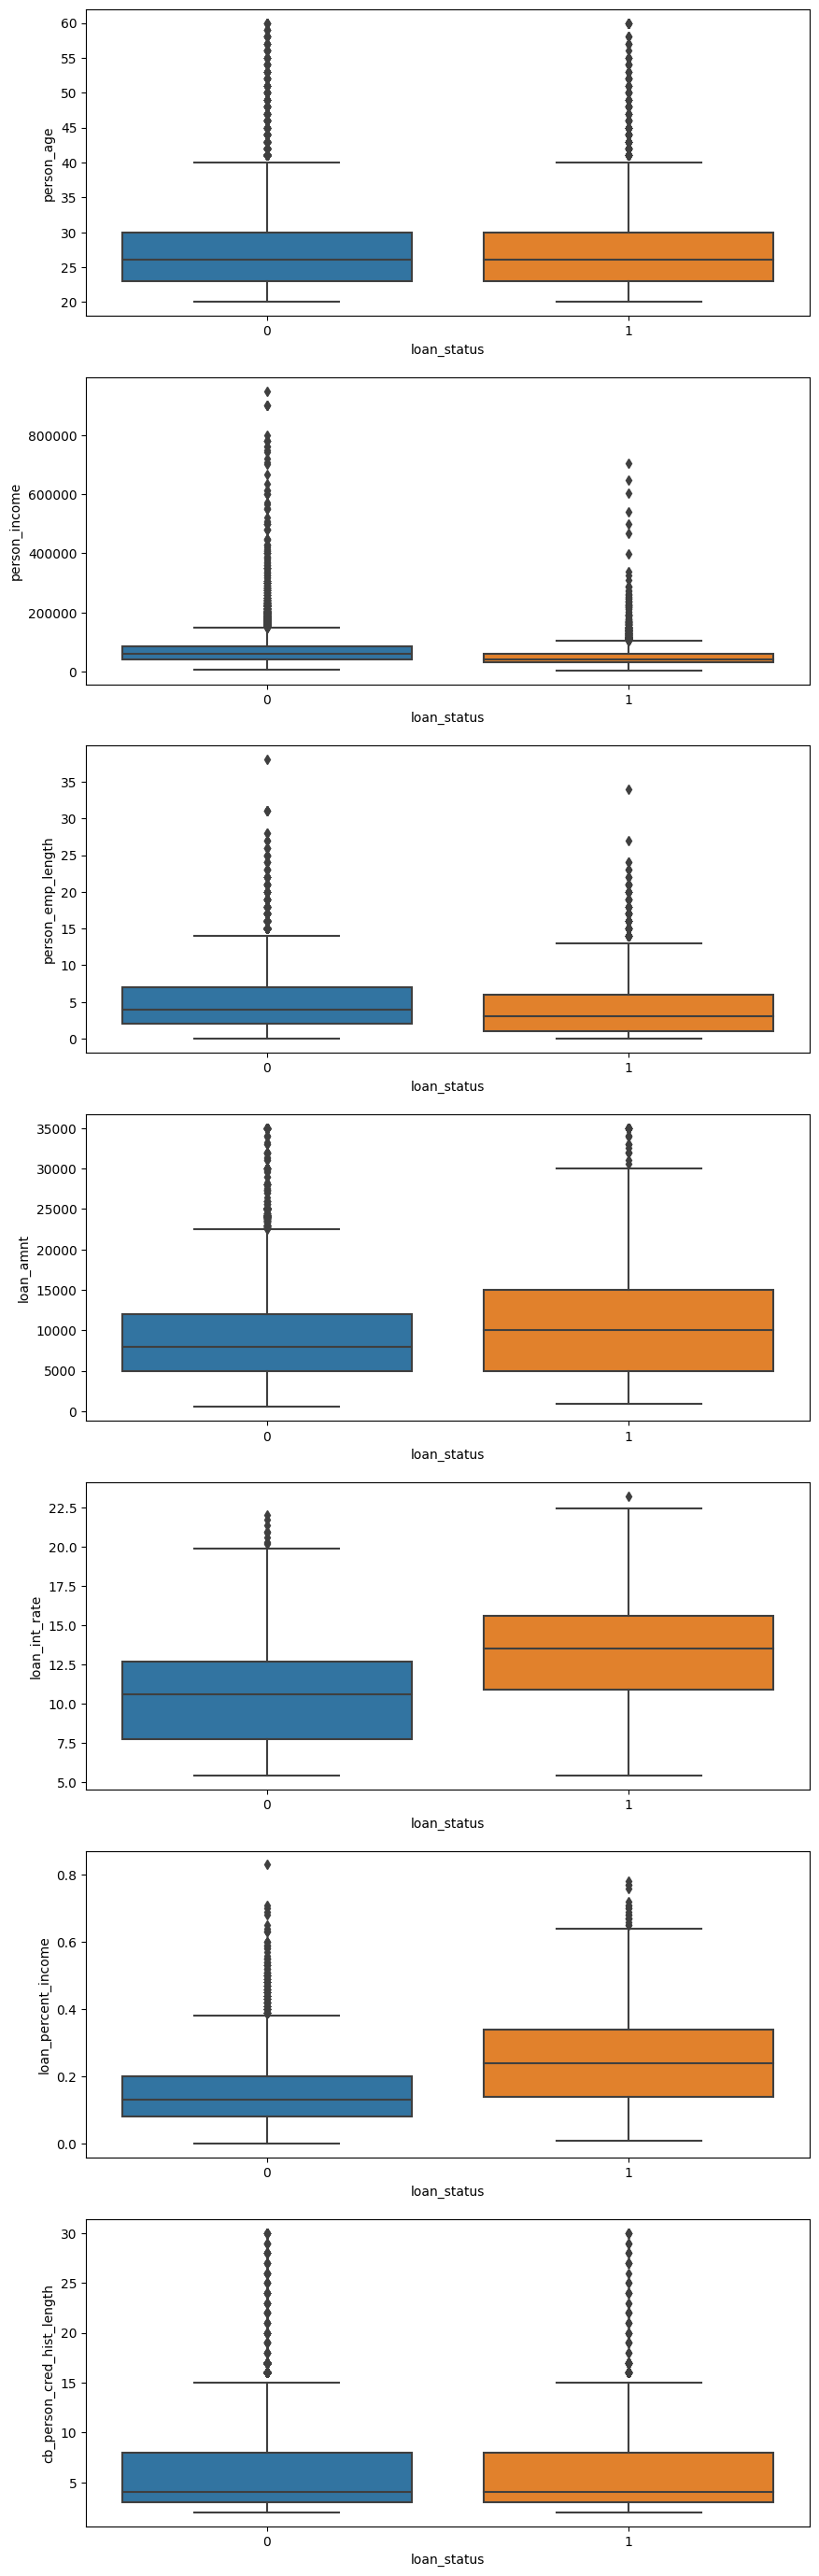

In [22]:
fig,axes = plt.subplots(nrows=len(data_num.columns), figsize=(10,len(data_num.columns)*5))
for i,j in zip(data_num.columns, range(0, len(data_num.columns))):
    sns.boxplot(x=y, y=data_num[i], ax=axes[j])

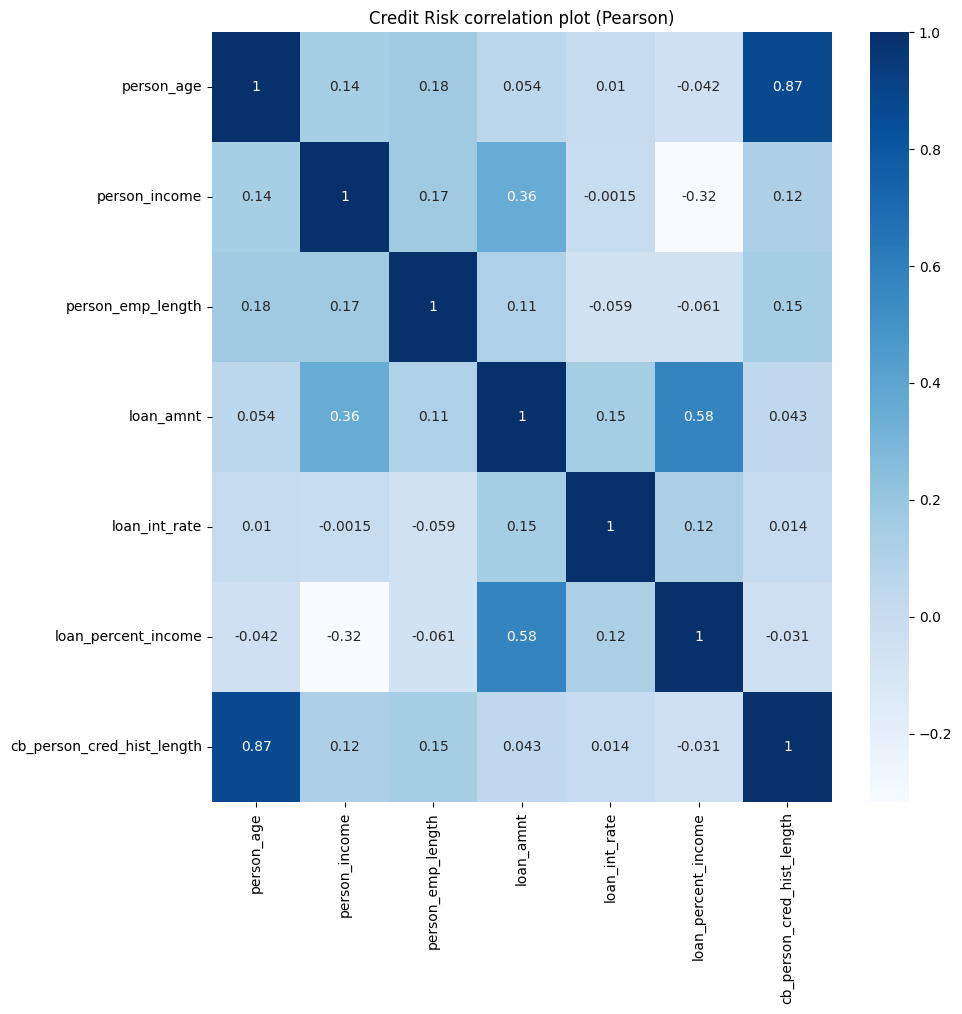

In [23]:
#Correlation matrix
plt.figure(figsize=(10,10))
plt.title('Credit Risk correlation plot (Pearson)')
sns.heatmap(data_num.corr(),annot=True,cmap='Blues')
plt.show()

In [24]:
def vif(df):
    ## Calculating VIF for numerical variables
    # VIF dataframe
    vif_data = pd.DataFrame()
    vif_data["feature"] = df.columns
    # calculating VIF for each feature
    vif_data["VIF"] = [variance_inflation_factor(df.values, i)
                              for i in range(len(df.columns))]
    # printing the vif values
    print(vif_data.sort_values('VIF', ascending=False))

In [25]:
vif(data_num.drop(['person_age', 'loan_amnt'], axis=1))

                      feature       VIF
2               loan_int_rate  6.364856
3         loan_percent_income  3.420350
0               person_income  3.030712
4  cb_person_cred_hist_length  3.030557
1           person_emp_length  2.415109


In [26]:
# dropping variables with high multicollinearity
data_num.drop(['person_age', 'loan_amnt'], axis=1, inplace=True)

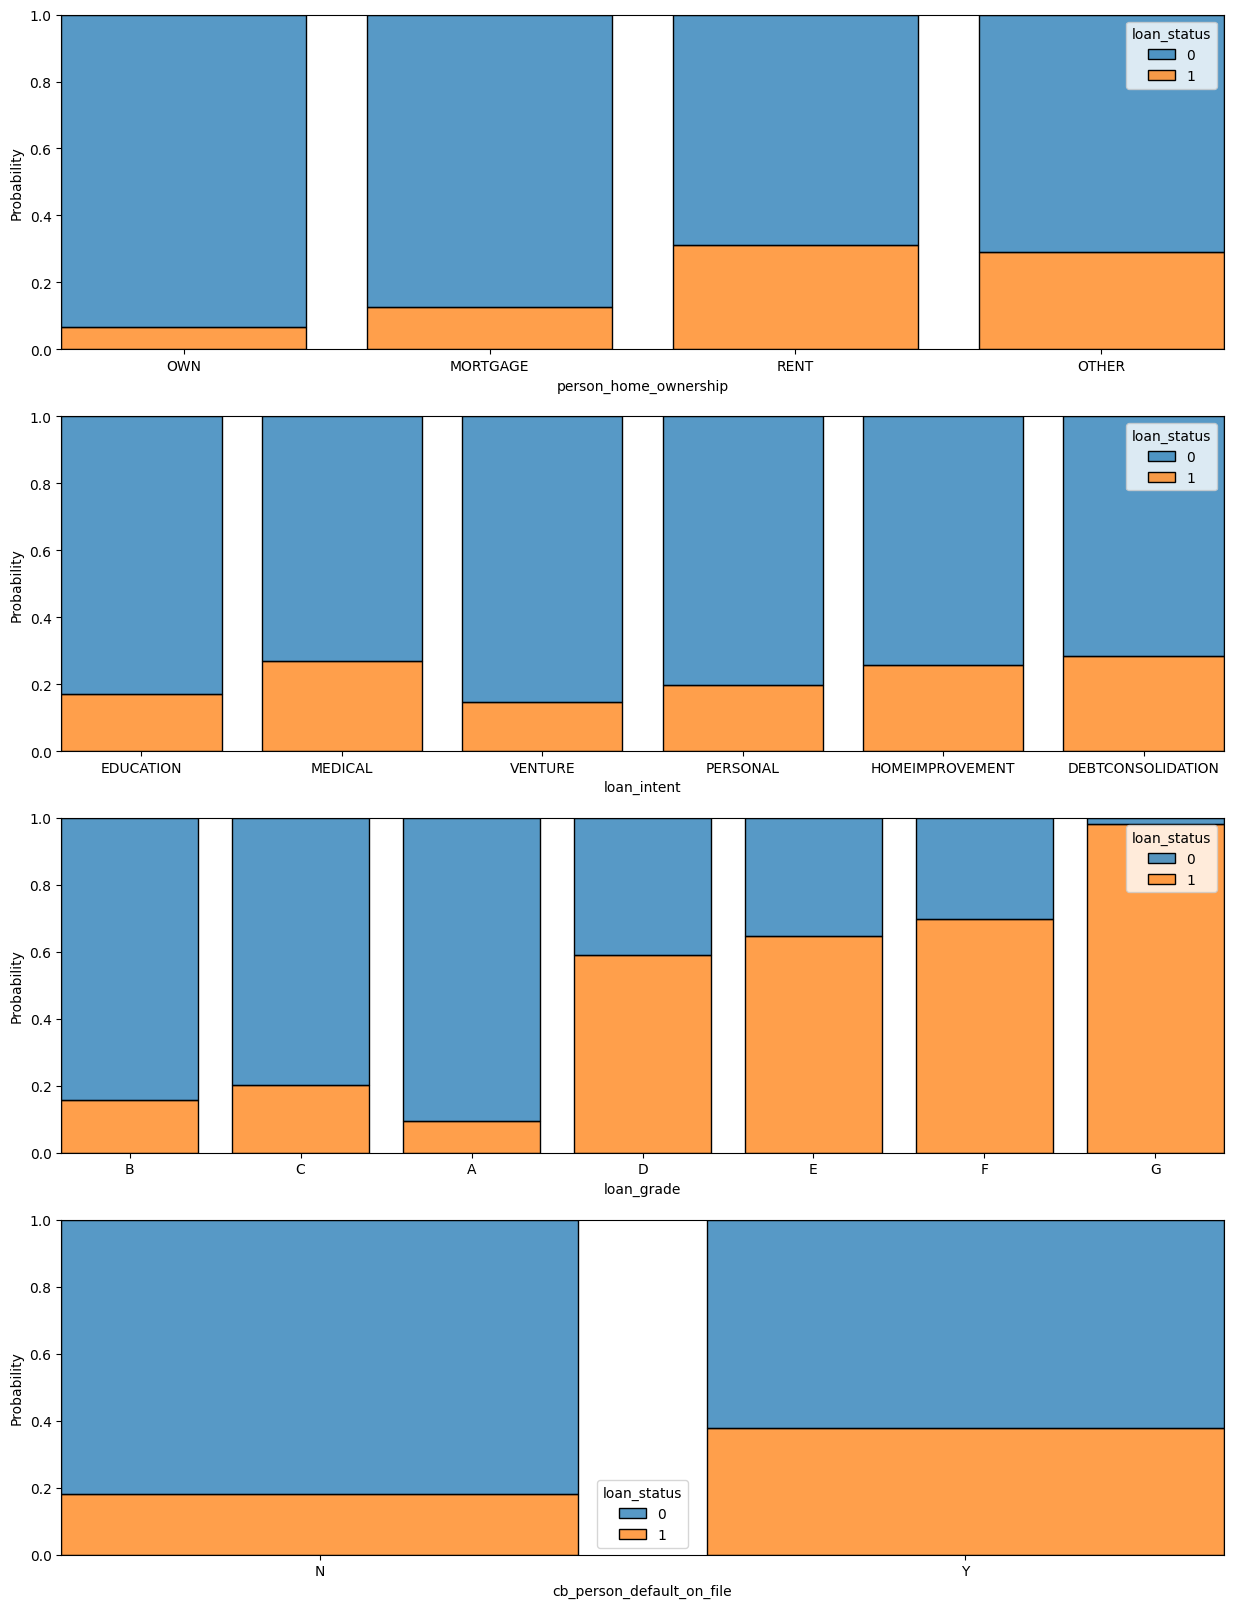

In [27]:
# Graph plotting for selecting categorical variables
fig,axes = plt.subplots(nrows=len(data_cat.columns), figsize=(15,len(data_cat.columns)*5))
for i,j in zip(data_cat.columns, range(0, len(data_cat.columns))):
    sns.histplot(x=data_cat[i], hue=y, ax=axes[j], stat="probability", multiple="fill", shrink=.8)

In [28]:
data_cat.drop(['loan_intent'], axis=1, inplace=True)

### Encoding

In [29]:
# Encoding of ordered data
ordinal_cols_mapping = [{
    "col":"loan_grade",    
    "mapping": {
        'A' : 1, 
        'B' : 2, 
        'C' : 3, 
        'D' : 4,
        'E' : 5,
        'F' : 6,
        'G' : 7,
    },
    },
]
ce_oe = ce.ordinal.OrdinalEncoder(mapping = ordinal_cols_mapping, return_df = True)  
data_cat = ce_oe.fit_transform(data_cat)

In [30]:
# Encoding of nominal data
ce_one_hot = ce.OneHotEncoder(cols = ['person_home_ownership', 'cb_person_default_on_file'], drop_invariant=True, use_cat_names=True)
data_cat = ce_one_hot.fit_transform(data_cat, y)
data_cat.drop(['person_home_ownership_OTHER', 'cb_person_default_on_file_N'], axis=1, inplace=True)

In [31]:
# Combine the numerical and categorical as a features matrix
features=pd.concat([data_num, data_cat], axis=1)
features

,person_income,person_emp_length,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,person_home_ownership_OWN,person_home_ownership_MORTGAGE,person_home_ownership_RENT,loan_grade,cb_person_default_on_file_Y
1,9600,5.0,11.14,0.10,2,1,0,0,2,0
2,9600,1.0,12.87,0.57,3,0,1,0,3,0
3,65500,4.0,15.23,0.53,2,0,0,1,3,0
4,54400,8.0,14.27,0.55,4,0,0,1,3,1
5,9900,2.0,7.14,0.25,2,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...
32574,65004,4.0,15.58,0.31,19,0,0,1,4,1
32575,64500,0.0,11.26,0.08,20,0,0,1,2,0
32576,53000,1.0,13.16,0.11,30,0,1,0,3,0
32577,120000,4.0,7.49,0.15,19,0,1,0,1,0


## Modelling

In [32]:
# Train-Test split
X_train, X_test, Y_train, Y_test = train_test_split(features, y, test_size = 0.2, random_state = 0)

In [33]:
# initializing some transformers for Feature Scaling
ss = StandardScaler()
rs = RobustScaler()
qt = QuantileTransformer(output_distribution='normal',n_quantiles=891)
yj = PowerTransformer(method = 'yeo-johnson')
bc = PowerTransformer(method = 'box-cox')
# Using box-cox transformer on the data
trans=bc
X_train_trans = pd.DataFrame(trans.fit_transform(X_train+0.0000000000001), index=X_train.index, columns=X_train.columns)
X_test_trans = pd.DataFrame(trans.transform(X_test+0.0000000000001), index=X_test.index, columns=X_test.columns)

In [34]:
# Defining a function which takes classifier and treshold value as arguments and model our data with it
# This will also print various evaluation metrics
# This function contains codes which are similar for all classifiers
def classify(classifier, thresh):
    # Fitting the model and making predictions
    model=classifier.fit(X_train_trans, Y_train)
    # Due to the objective of our problem we require a Low False Positive Rate and therefore High Precision.
    # To do this we change our threshold value to where our accuracy is at least 90%.
    # Thereafter we calculate the accuracy of the model.
    pred = (classifier.predict_proba(X_test_trans)[:,1] >= thresh).astype(bool)
    
    # Check
    fb=check(classifier)
    if fb is 'n':
        return fb

    # Calculating various evaluation metrics
    score=classifier.score(X_train_trans, Y_train)
    accuracy = accuracy_score(Y_test, pred)
    precision = precision_score(Y_test, pred)
    recall = recall_score(Y_test, pred)
    fscore = f1_score(Y_test, pred)
    auc_score = roc_auc_score(Y_test, classifier.predict_proba(X_test_trans)[:,1])
    cr = classification_report(Y_test, pred)

    # Printing the scores
    print(f'Accuracy train data:{score}')
    print(f'Accuracy test data:{accuracy}')
    print(f'Precision:{precision}')
    print(f'Recall:{recall}')
    print(f'F1_score:{fscore}')
    print(f'AUC score:{auc_score}')
    print('\n \t\t\t CLASSIFICATION REPORT \n', cr)

    # Confusion Matrix
    plt.figure(figsize=(3,3))
    sns.heatmap(confusion_matrix(Y_test,pred), annot=True, cmap='Blues', fmt='g', cbar=False)
    plt.xlabel("Predicted Values", fontsize=14)
    plt.title("Confusion Matrix", fontsize=14, fontweight='bold')
    plt.ylabel("Actual Values", fontsize=14)
    plt.show()

    # Calculating roc-auc
    fpr, tpr, thresholds = roc_curve(Y_test,classifier.predict_proba(X_test_trans)[:,1])
    roc_auc=auc(fpr, tpr)
    # Plotting the ROC curve
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

In [35]:
def check(classifier):
    if classifier is lr:
        linearity_check()
        fb=input('Continue? y\n')
        if fb is 'n':
            return fb
    if classifier is dtc:
        plot_tree()

In [36]:
# Linearity check for Logistic Regression
def linearity_check():
    # Modelling Logistic Regression with statsmodels
    X_exog=sm.add_constant(X_train_trans)
    model=sm.Logit(Y_train.ravel(), X_exog)
    mfit=model.fit()
    print(mfit.summary())
    # get predicted values on training data
    pred_lr=mfit.predict(X_exog)
    # Get log odds values
    log_odds = np.log(pred_lr / (1 - pred_lr))
    log_odds.name="log_odds"
    # Visualize predictor continuous variable vs logit values (Age)
    fig,axes = plt.subplots(nrows=len(X_train_trans.columns), figsize=(10,100))
    for i,j in zip(X_train_trans.columns, range(0, len(X_train_trans.columns))):
        sns.scatterplot(x = X_train_trans[i], y=log_odds, s=10, ax=axes[j])
    plt.show()

In [37]:
# Function to plot a decision tree
def plot_tree():
    fig = plt.figure(figsize=(50,50))
    _ = tree.plot_tree(clf, 
                       feature_names=X_train_trans.columns.to_list(),  
                       class_names=['No Default', 'Default'],
                       filled=True)

In [38]:
# Initializing a few of the classifiers
lr = LogisticRegression(random_state = 25, solver='newton-cholesky', penalty="l2", C=1)
gnb = GaussianNB()
knn=KNeighborsClassifier(n_neighbors=87, weights='uniform')
dtc = DecisionTreeClassifier(random_state=25, max_depth=3, min_samples_split=5, max_features=4)
rfc = RandomForestClassifier(random_state=25, max_depth=5, min_samples_split=5, max_features=4)

Optimization terminated successfully.
         Current function value: 0.373951
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                22748
Model:                          Logit   Df Residuals:                    22737
Method:                           MLE   Df Model:                           10
Date:                Fri, 07 Jul 2023   Pseudo R-squ.:                  0.2870
Time:                        21:05:59   Log-Likelihood:                -8506.6
converged:                       True   LL-Null:                       -11931.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                     coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const                             -1.9529      0.026    -75.316     

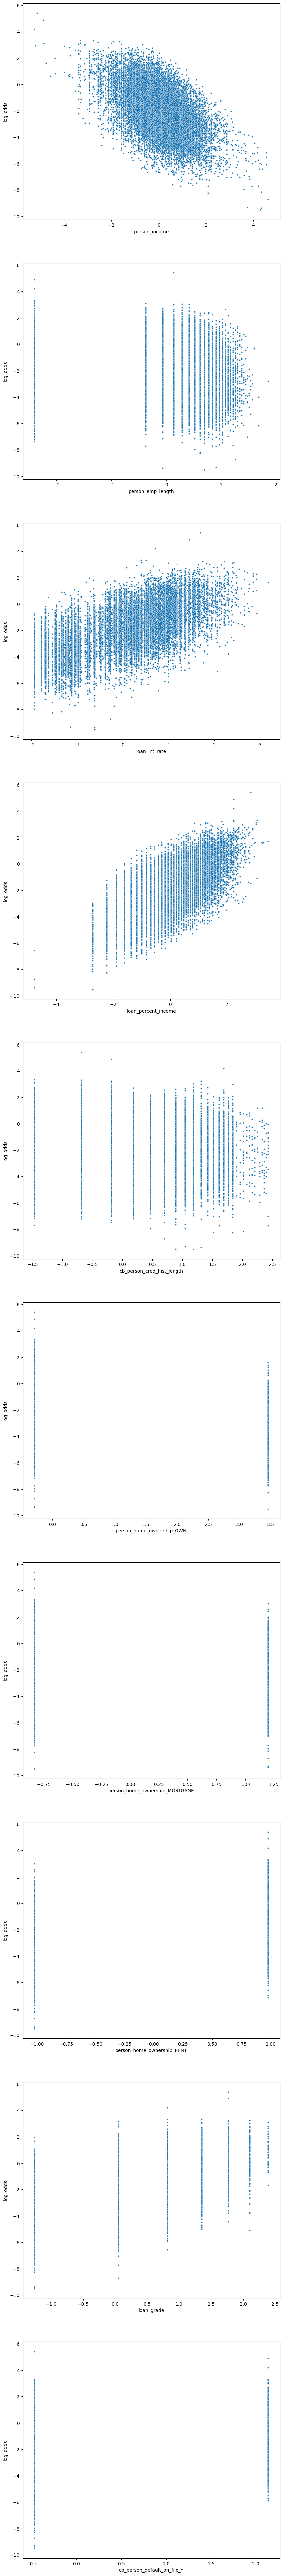

Continue? y

Accuracy train data:0.8423597678916828
Accuracy test data:0.8162798874824191
Precision:0.9191919191919192
Recall:0.15028901734104047
F1_score:0.2583392476933996
AUC score:0.8408040951393552

 			 CLASSIFICATION REPORT 
               precision    recall  f1-score   support

           0       0.81      1.00      0.90      4477
           1       0.92      0.15      0.26      1211

    accuracy                           0.82      5688
   macro avg       0.87      0.57      0.58      5688
weighted avg       0.84      0.82      0.76      5688



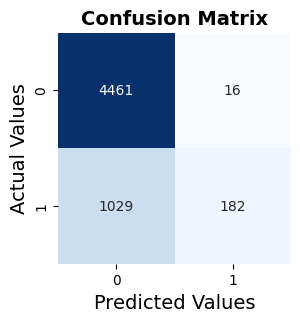

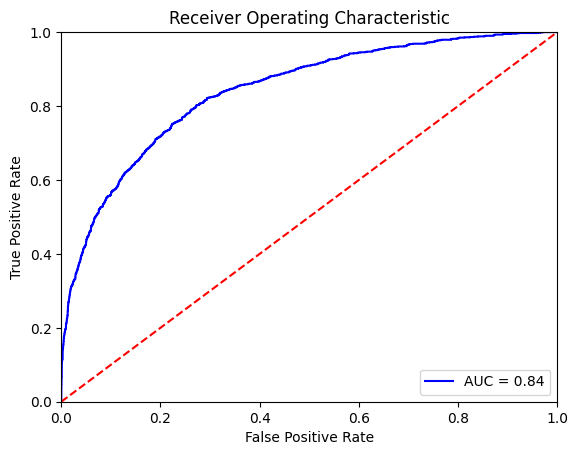

In [39]:
# Modelling with Logistic Regression
clf=lr
classify(classifier=clf, thresh=0.75)

Accuracy train data:0.7867065236504308
Accuracy test data:0.8020393811533052
Precision:0.9047619047619048
Recall:0.07844756399669695
F1_score:0.14437689969604864
AUC score:0.8146011719317026

 			 CLASSIFICATION REPORT 
               precision    recall  f1-score   support

           0       0.80      1.00      0.89      4477
           1       0.90      0.08      0.14      1211

    accuracy                           0.80      5688
   macro avg       0.85      0.54      0.52      5688
weighted avg       0.82      0.80      0.73      5688



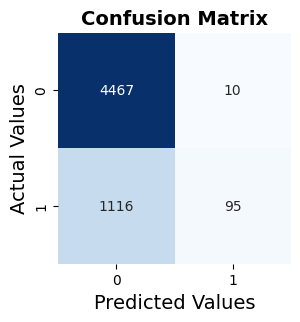

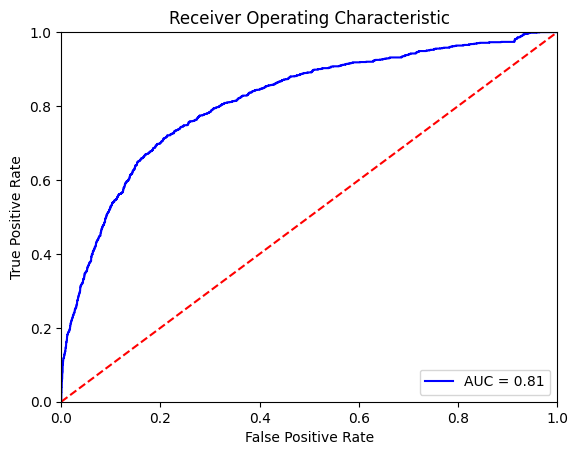

In [40]:
# Modelling with Naive Bayes'
clf=gnb
classify(classifier=clf, thresh=0.995)

Accuracy train data:0.871900826446281
Accuracy test data:0.8602320675105485
Precision:0.9031007751937985
Recall:0.38480594549958713
F1_score:0.5396641574985525
AUC score:0.8848270645433021

 			 CLASSIFICATION REPORT 
               precision    recall  f1-score   support

           0       0.86      0.99      0.92      4477
           1       0.90      0.38      0.54      1211

    accuracy                           0.86      5688
   macro avg       0.88      0.69      0.73      5688
weighted avg       0.87      0.86      0.84      5688



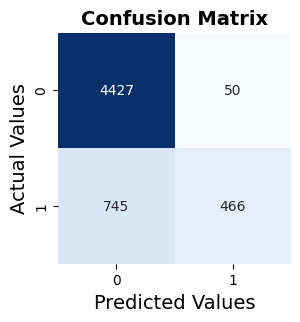

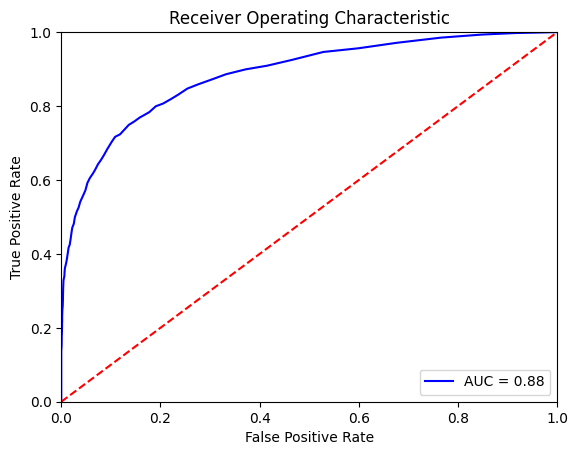

In [41]:
# Modelling with K-Nearest Neighbours
clf=knn
classify(classifier=clf, thresh=0.55)

Accuracy train data:0.8420080886231757
Accuracy test data:0.8437060478199718
Precision:0.896551724137931
Recall:0.30057803468208094
F1_score:0.45021645021645024
AUC score:0.7778888961232628

 			 CLASSIFICATION REPORT 
               precision    recall  f1-score   support

           0       0.84      0.99      0.91      4477
           1       0.90      0.30      0.45      1211

    accuracy                           0.84      5688
   macro avg       0.87      0.65      0.68      5688
weighted avg       0.85      0.84      0.81      5688



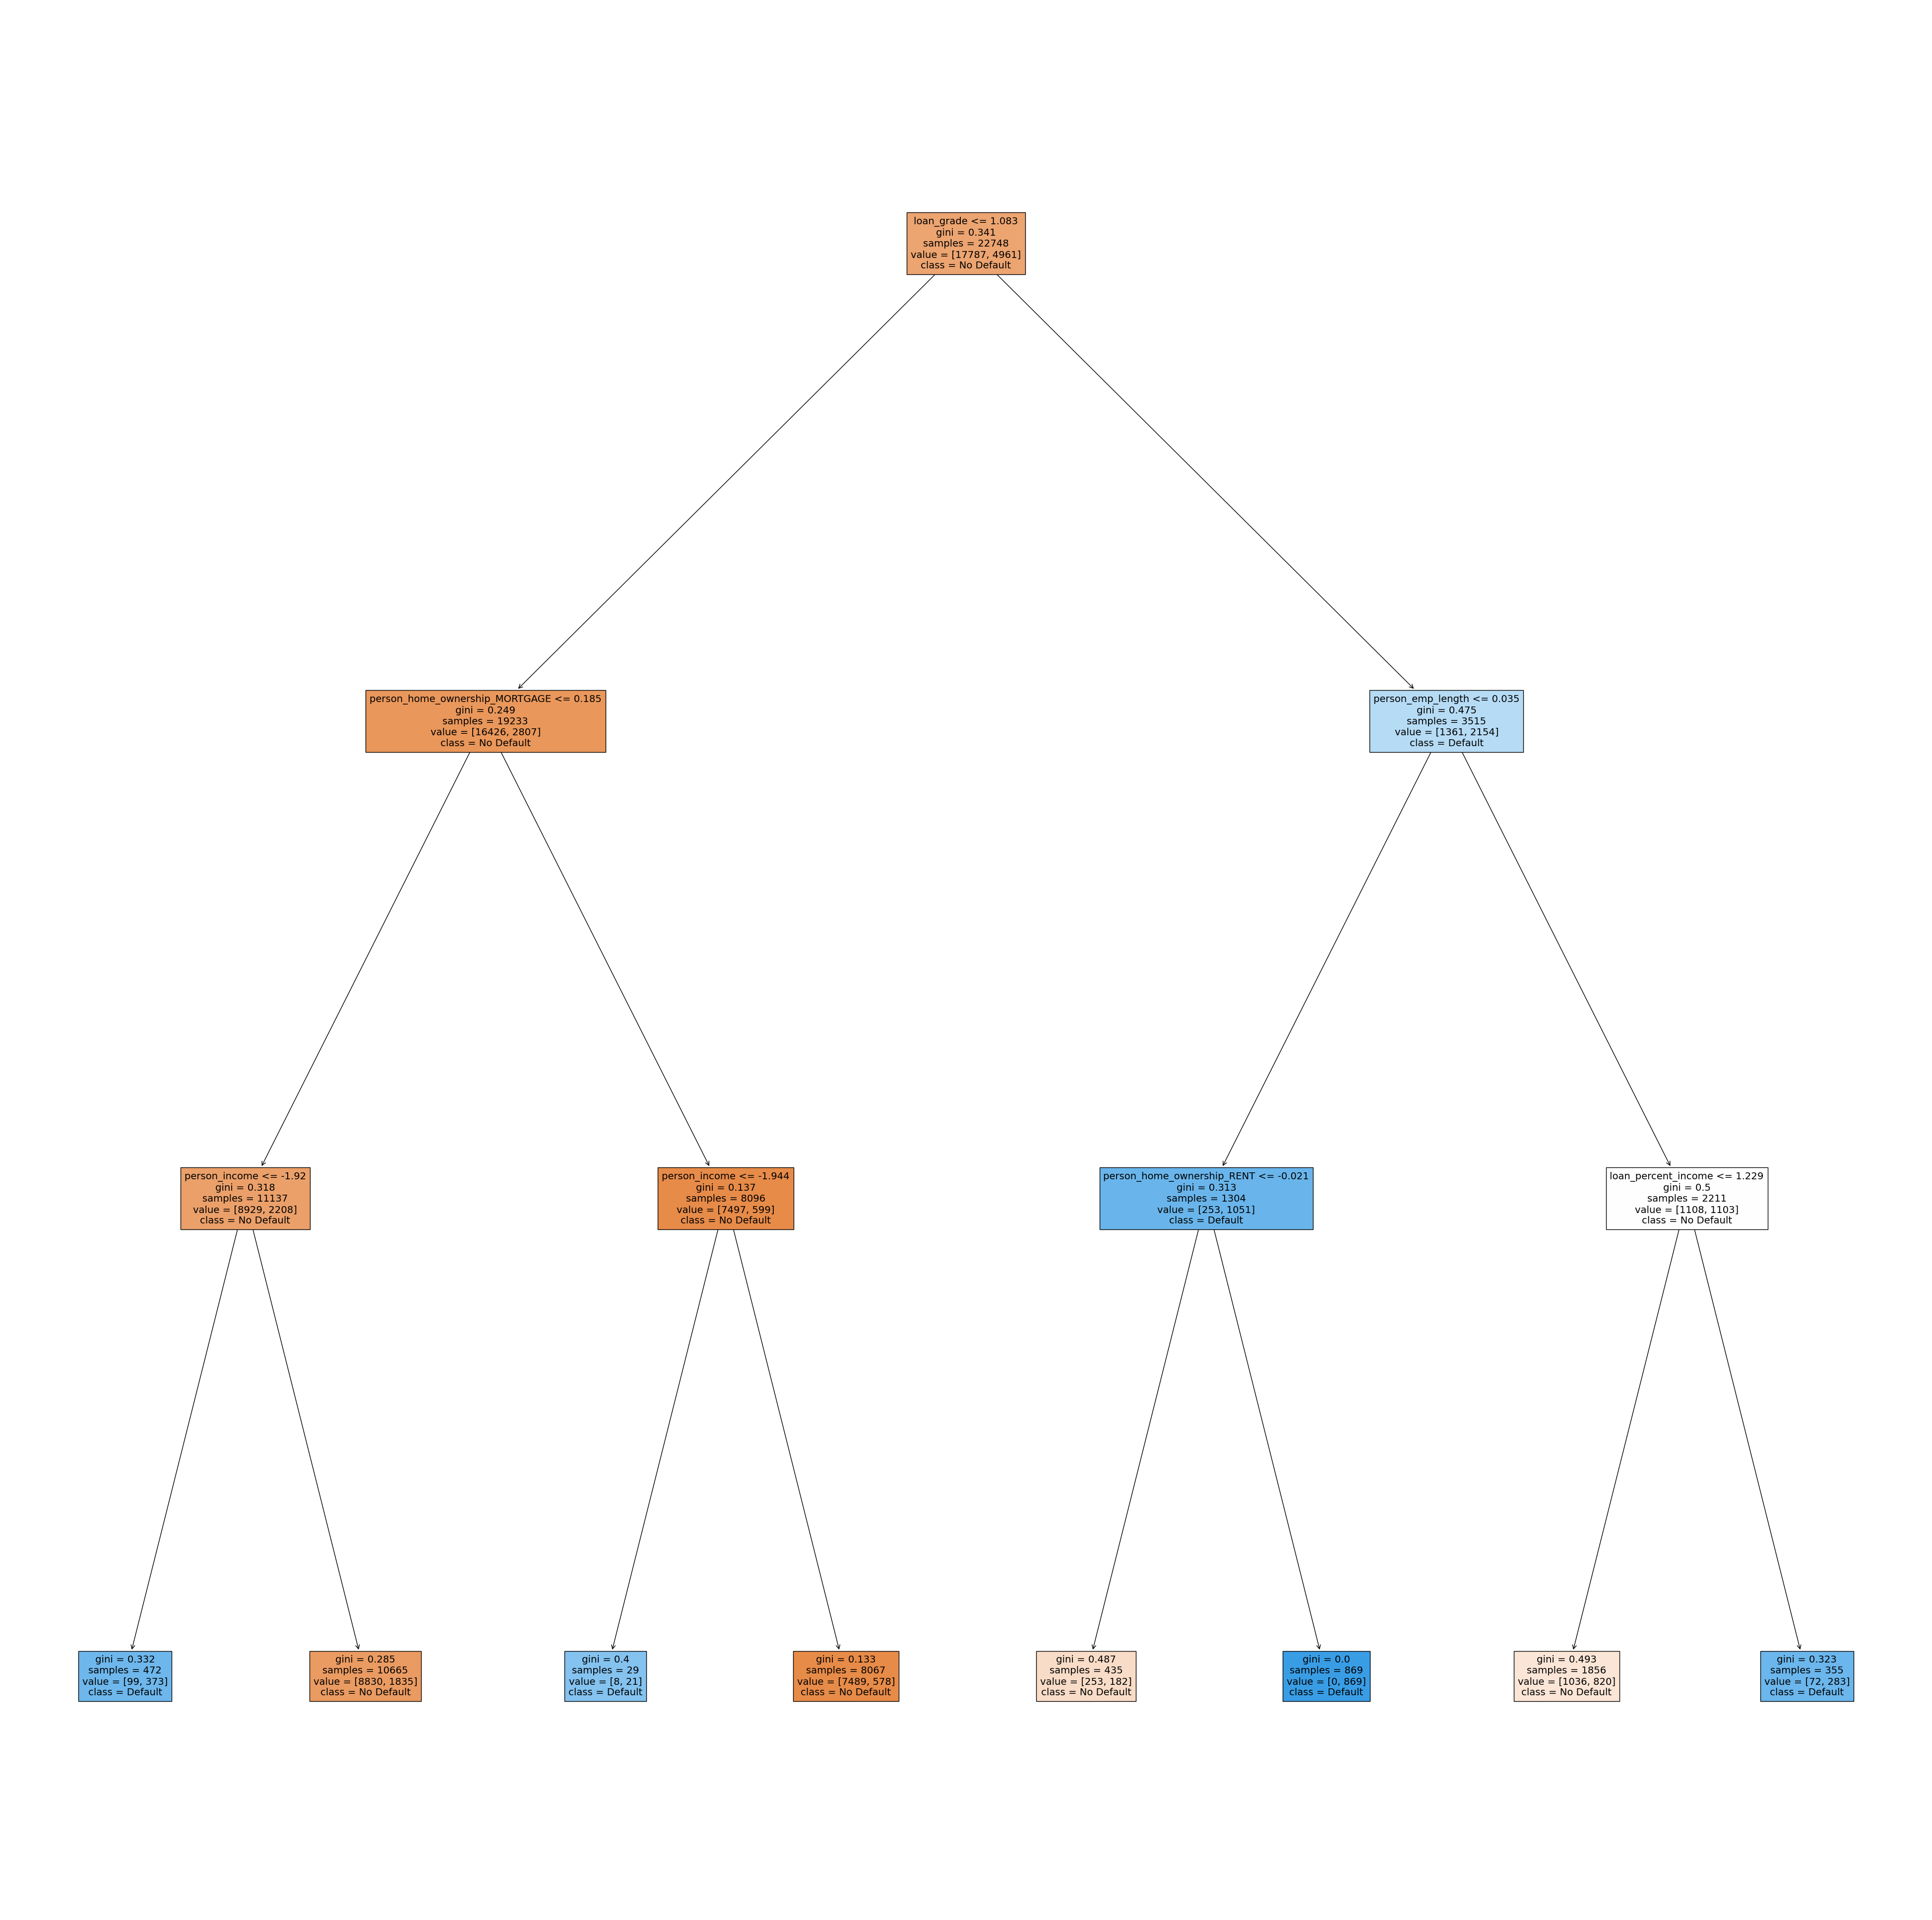

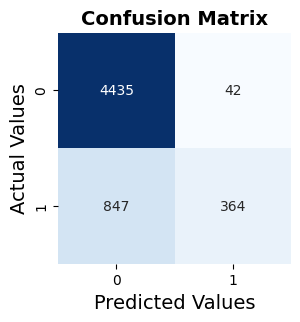

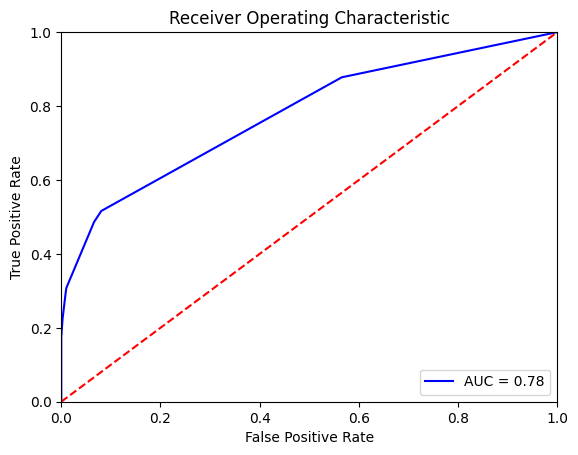

In [42]:
# Modelling with Decision Tree Classifier
clf=dtc
classify(classifier=clf, thresh=0.73)

Accuracy train data:0.90469491823457
Accuracy test data:0.9043600562587905
Precision:0.9102091020910209
Recall:0.611065235342692
F1_score:0.7312252964426876
AUC score:0.901167302113177

 			 CLASSIFICATION REPORT 
               precision    recall  f1-score   support

           0       0.90      0.98      0.94      4477
           1       0.91      0.61      0.73      1211

    accuracy                           0.90      5688
   macro avg       0.91      0.80      0.84      5688
weighted avg       0.90      0.90      0.90      5688



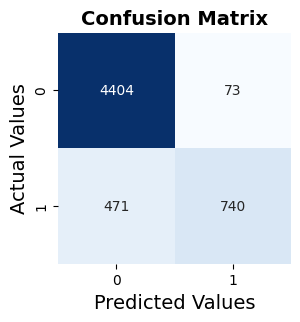

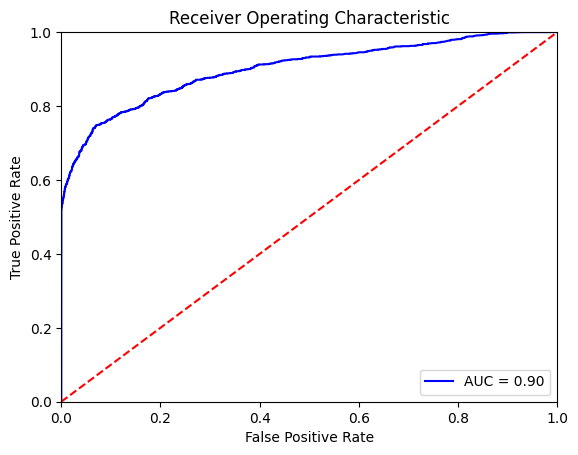

In [43]:
# Modelling with Random Forest Classifier
clf=rfc
classify(classifier=clf, thresh=0.50)